In [88]:
from imprint.nb_util import setup_nb
setup_nb()

import jax
import jax.numpy as jnp
import numpy as np
import scipy
import matplotlib.pyplot as plt
import imprint.bound.normal as normal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
def tie(theta, thresh):
    return scipy.stats.norm.sf(thresh-theta)

In [109]:
theta0 = -0.25
theta = 0
alpha = 0.025
z_crit = scipy.stats.norm.isf(alpha)

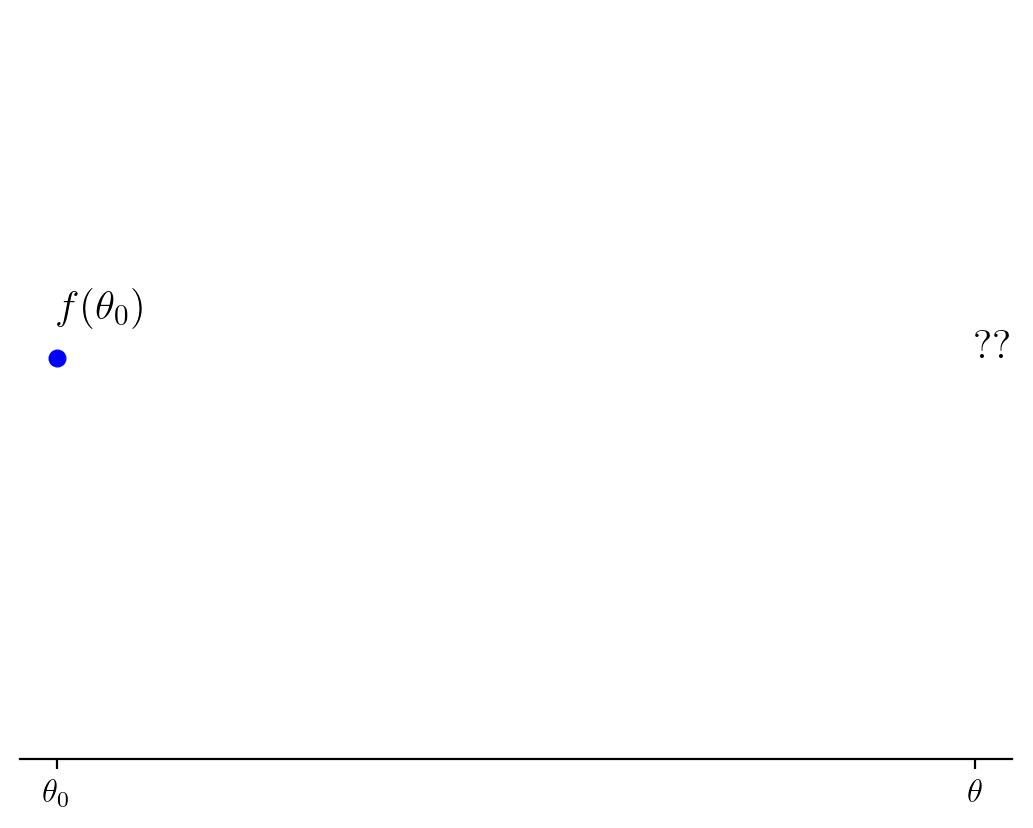

In [110]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
tie0 = tie(theta0, z_crit)
xeps, yeps = 0, tie0 * 0.1
ax.scatter(theta0, tie0, s=30, color='b')
ax.annotate(f'$f(\\theta_{0})$', (theta0 + xeps, tie0 + yeps))
ax.annotate(f'$??$', (theta, tie0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.axes.set_xticks([theta0, theta], labels=['$\\theta_0$', '$\\theta$'])
ax.set_xlim(left=theta0-0.01, right=theta+0.01)
ax.set_ylim(bottom=0, top=alpha)
plt.savefig('figures/cse_problem.pdf', bbox_inches='tight')
plt.show()

In [111]:
fwd_solver = normal.ForwardQCPSolver(1)
vs = jnp.linspace(theta0, theta, num=100, endpoint=True) - theta0
qs = jax.vmap(fwd_solver.solve, in_axes=(0, None))(vs, tie0)
bounds = jax.vmap(normal.tilt_bound_fwd_tile, in_axes=(0, None, 0, None))(qs, 1, vs[:,  None, None], tie0)

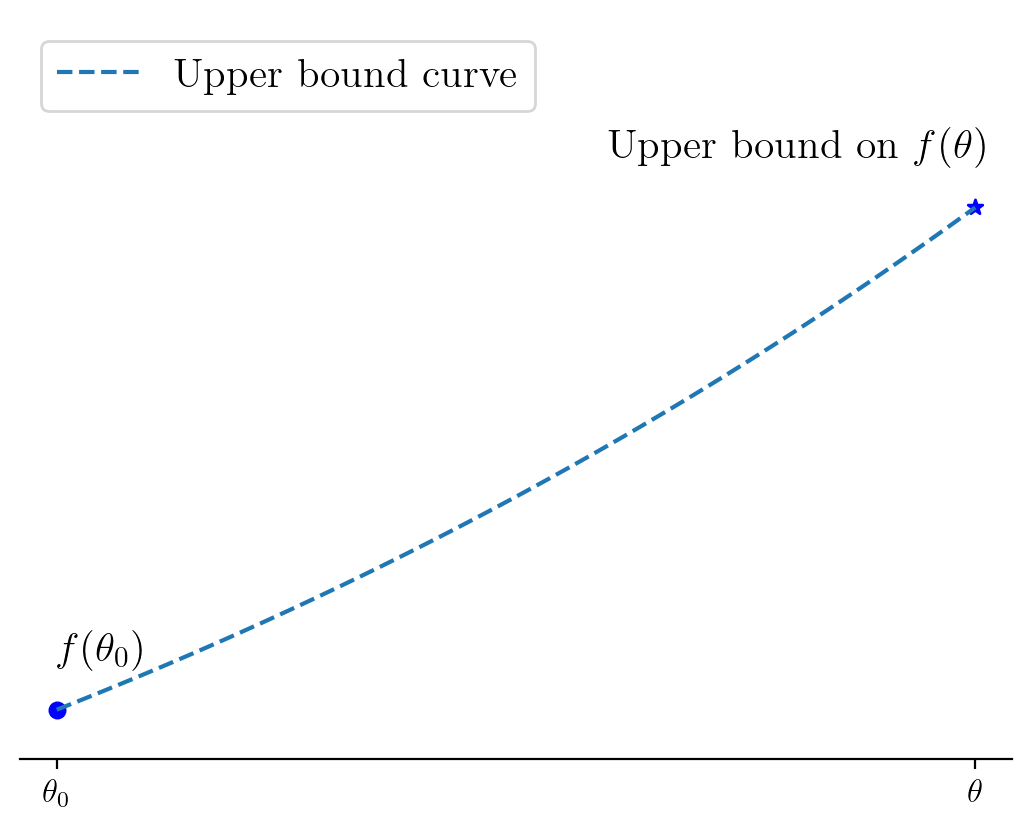

In [119]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
tie0 = tie(theta0, z_crit)
xeps, yeps = 0, tie0 * 0.1
ax.plot(theta0 + vs, bounds, linestyle='--', label='Upper bound curve')
ax.scatter(theta0, tie0, s=30, color='b')
ax.scatter(theta, bounds[-1], s=30, color='b', marker='*')
ax.annotate(f'$f(\\theta_{0})$', (theta0 + xeps, tie0 + yeps))
ax.annotate(f'Upper bound on $f(\\theta)$', (theta-1e-1, bounds[-1] * 1.05))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.axes.set_xticks([theta0, theta], labels=['$\\theta_0$', '$\\theta$'])
ax.set_xlim(left=theta0-0.01, right=theta+0.01)
ax.set_ylim(bottom=tie0 * 0.9, top=alpha * 1.3)
plt.legend(loc='upper left')
plt.savefig('figures/cse_solution.pdf', bbox_inches='tight')
plt.show()

In [179]:
# Bounds for a fixed list of q's
qlist = 2 ** np.linspace(9, 4, 6)
vlist = np.linspace(0, theta-theta0, 2000)
outputs = jax.vmap(
    jax.vmap(normal.tilt_bound_fwd_tile, in_axes=(None, None, 0, None)),
    in_axes=(0, None, None, None),
)(qlist, 1, vlist, tie0)
qlist, outputs.shape

(array([512., 256., 128.,  64.,  32.,  16.]), (6, 2000))

In [180]:
fwd_solve_vmap = jax.vmap(fwd_solver.solve, in_axes=(0, None))
fwd_bound_vmap = jax.vmap(normal.tilt_bound_fwd_tile, in_axes=(0, None, 0, None))
optqs = fwd_solve_vmap(vlist, tie0)
optbound = fwd_bound_vmap(optqs, 1, vlist, tie0)

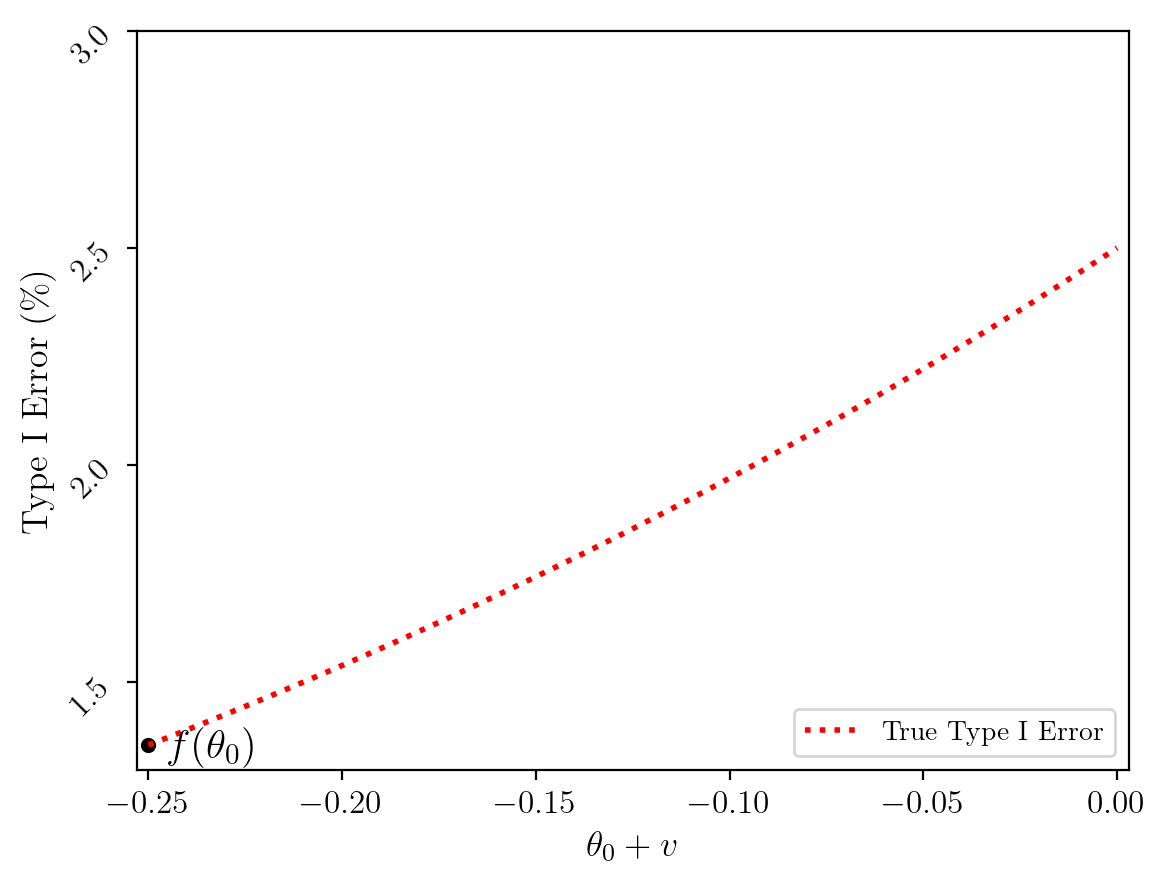

In [202]:
x = theta0 + vlist
linestylelist = [":"] * len(qlist)
colorlist = ["g"] * len(qlist)
true_ties = tie(x, z_crit)

plt.plot(x, true_ties, "r:", linewidth=2, label="True Type I Error")
plt.scatter(theta0, tie0, color="k", marker="o", s=20)
plt.annotate("$f(\\theta_0)$", (theta0 * 0.98, tie0 * 0.98))

plt.xlabel("$\\theta_0 + v$")
plt.ylabel("Type I Error ($\%$)")
yticks = np.linspace(0.015, 0.03, 4)
plt.yticks(
    yticks,
    labels=[f"{(yv * 100):.1f}" for yv in yticks],
    rotation=45,
    ha="right",
)
plt.xlim([-0.253, 0.003])
plt.legend(loc="lower right", fontsize=10)
plt.savefig("figures/greens_up_tie.pdf", bbox_inches="tight")

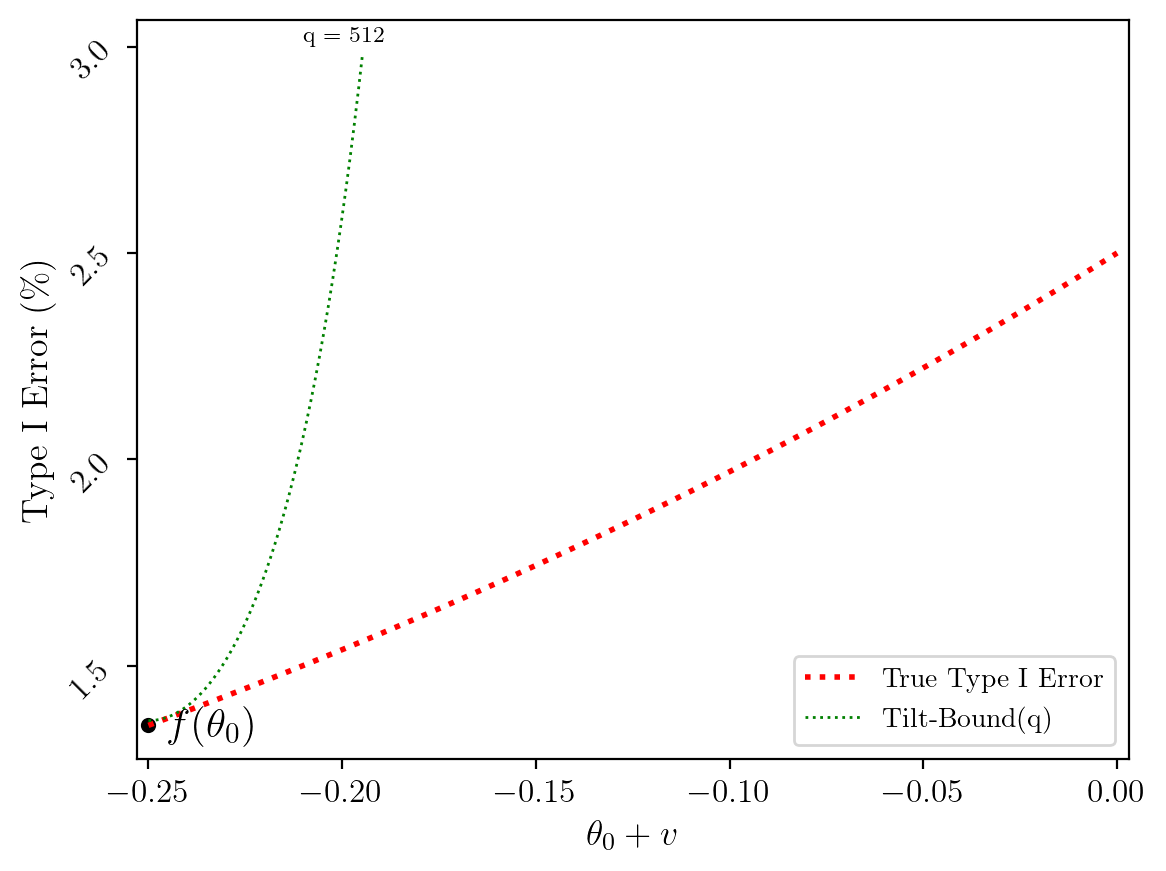

In [203]:
plt.plot(x, true_ties, "r:", linewidth=2, label="True Type I Error")
plt.scatter(theta0, tie0, color="k", marker="o", s=20)
plt.annotate("$f(\\theta_0)$", (theta0 * 0.98, tie0 * 0.98))

# plot just 1 one of tilt-bounds
filter = outputs[0] < 0.0299
plt.plot(
    x[filter], 
    outputs[0, filter],
    "g",
    linewidth=1,
    linestyle=linestylelist[0],
    label='Tilt-Bound(q)'
)
plt.text(-0.21, 0.0301, "q = 512", fontsize=8)

plt.xlabel("$\\theta_0 + v$")
plt.ylabel("Type I Error ($\%$)")
yticks = np.linspace(0.015, 0.03, 4)
plt.yticks(
    yticks,
    labels=[f"{(yv * 100):.1f}" for yv in yticks],
    rotation=45,
    ha="right",
)
plt.xlim([-0.253, 0.003])
plt.legend(loc="lower right", fontsize=10)
plt.savefig('figures/greens_up_one_q.pdf', bbox_inches='tight')

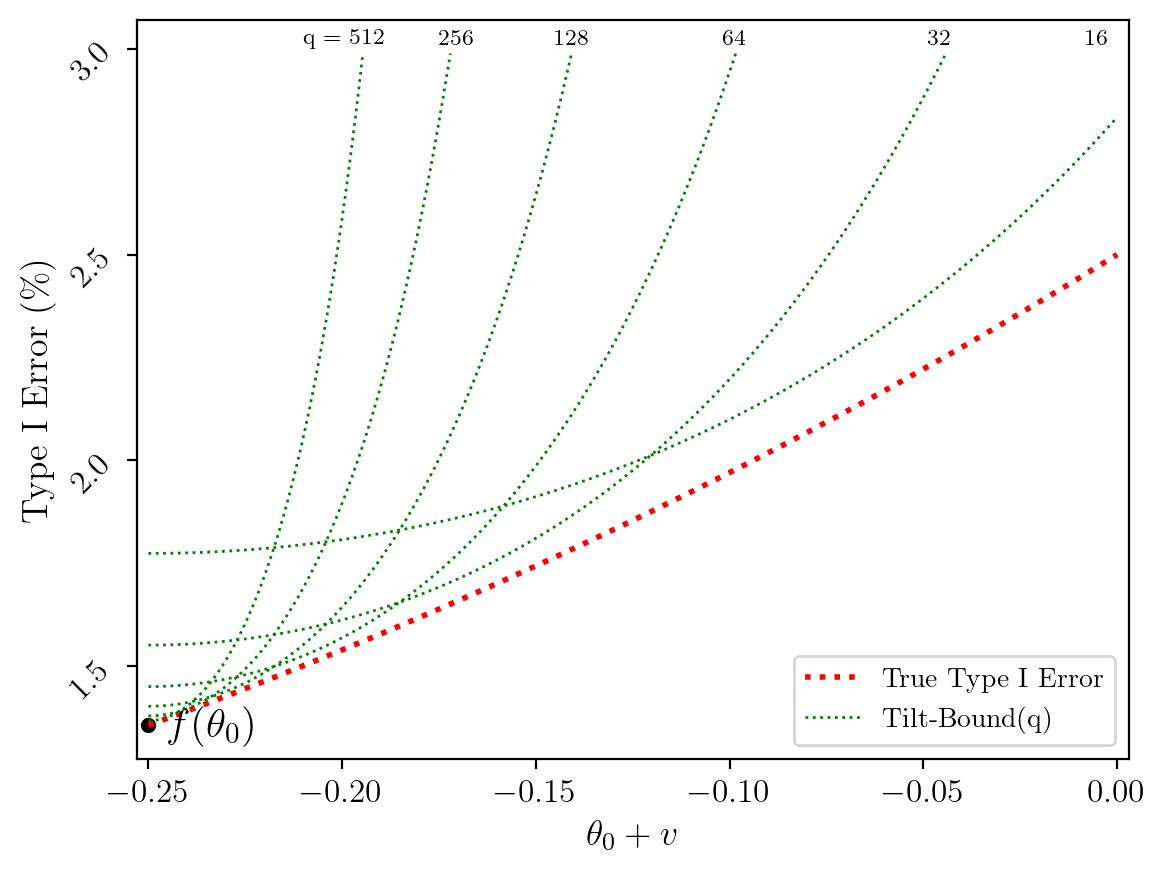

In [204]:
plt.plot(x, true_ties, "r:", linewidth=2, label="True Type I Error")
plt.scatter(theta0, tie0, color="k", marker="o", s=20)
plt.annotate("$f(\\theta_0)$", (theta0 * 0.98, tie0 * 0.98))

# Plotting for 6 different choices of q, ranging from 2^4 to 2^9
for i in range(len(qlist)):
    filter = outputs[i] < 0.0299
    label = "Tilt-Bound(q)" if i == 0 else None
    plt.plot(
        x[filter], 
        outputs[i, filter],
        "g",
        linewidth=1,
        linestyle=linestylelist[i],
        label=label
    )
plt.text(-0.21, 0.0301, "q = 512", fontsize=8)
plt.text(-0.175, 0.0301, "256", fontsize=8)
plt.text(-0.145, 0.0301, "128", fontsize=8)
plt.text(-0.102, 0.0301, "64", fontsize=8)
plt.text(-0.049, 0.0301, "32", fontsize=8)
plt.text(-0.008, 0.0301, "16", fontsize=8)

plt.xlabel("$\\theta_0 + v$")
plt.ylabel("Type I Error ($\%$)")
yticks = np.linspace(0.015, 0.03, 4)
plt.yticks(
    yticks,
    labels=[f"{(yv * 100):.1f}" for yv in yticks],
    rotation=45,
    ha="right",
)
plt.xlim([-0.253, 0.003])
plt.legend(loc="lower right", fontsize=10)
plt.savefig('figures/greens_up_all_q.pdf', bbox_inches='tight')

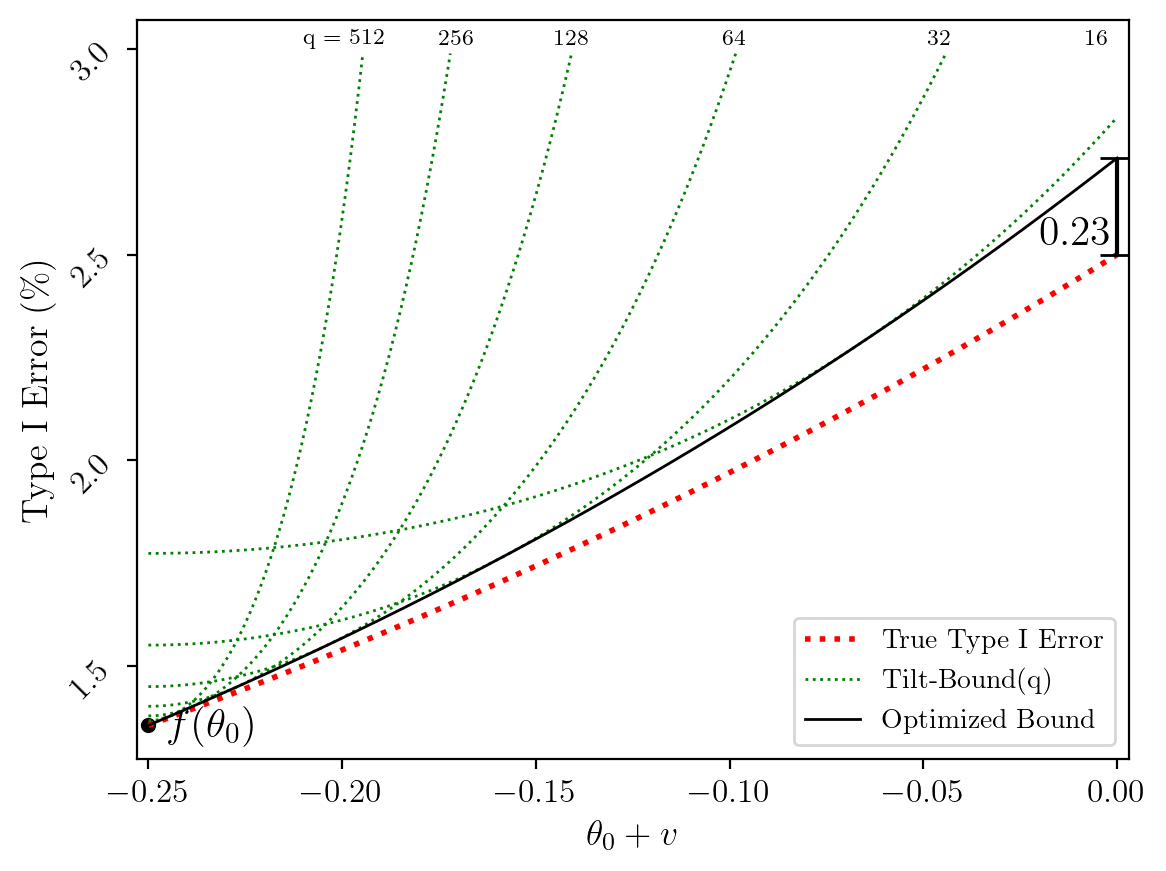

In [205]:
plt.plot(x, true_ties, "r:", linewidth=2, label="True Type I Error")
plt.scatter(theta0, tie0, color="k", marker="o", s=20)
plt.annotate("$f(\\theta_0)$", (theta0 * 0.98, tie0 * 0.98))

# Plotting for 6 different choices of q, ranging from 2^4 to 2^9
for i in range(len(qlist)):
    filter = outputs[i] < 0.0299
    label = "Tilt-Bound(q)" if i == 0 else None
    plt.plot(
        x[filter], 
        outputs[i, filter],
        "g",
        linewidth=1,
        linestyle=linestylelist[i],
        label=label
    )
plt.text(-0.21, 0.0301, "q = 512", fontsize=8)
plt.text(-0.175, 0.0301, "256", fontsize=8)
plt.text(-0.145, 0.0301, "128", fontsize=8)
plt.text(-0.102, 0.0301, "64", fontsize=8)
plt.text(-0.049, 0.0301, "32", fontsize=8)
plt.text(-0.008, 0.0301, "16", fontsize=8)

# Now plotting the optimal
filter = optbound < 0.3
plt.plot(x[filter], optbound[filter], "k", linewidth=1, label="Optimized Bound")

# Plot the maximum difference
x_last = x[filter][-1]
tie_last = tie(x_last, z_crit)
yerr = optbound[filter][-1] - tie_last
plt.errorbar(
    x_last, tie_last + yerr / 2,
    yerr=yerr / 2,
    fmt='none',
    ecolor='black',
    capsize=6,
)
plt.annotate(f"{yerr * 100:.2f}", (x_last-2e-2, tie_last + yerr / 10))

plt.xlabel("$\\theta_0 + v$")
plt.ylabel("Type I Error ($\%$)")
yticks = np.linspace(0.015, 0.03, 4)
plt.yticks(
    yticks,
    labels=[f"{(yv * 100):.1f}" for yv in yticks],
    rotation=45,
    ha="right",
)
plt.xlim([-0.253, 0.003])
plt.legend(loc="lower right", fontsize=10)
plt.savefig('figures/greens_up.pdf', bbox_inches='tight')